# How accurate is the price concessions predictor?

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import  DateFormatter
%matplotlib inline
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

The DataLab created a predictive tool to help NHS England, CCGs, PCNs and practice to understand the impact of price concessions on their spend.  Give the delay in getting prescribing data for the month involved, the tool uses the latest avaialble prescribing data, which is two months behind.

Therefore, to calculate the effect of the price concession for May 2020, the tool will:

- Calculate the total quantity of the affected medicine for March 2020 (the latest data avialable)
- Multiply this by both the drug tariff cost and the price concession cost
- Apply a discount factor (currently around 7.2% on Tariff prices)

to get an estimate for May 2020.

As the tool is being used by a number of people, and is a couple of years old, we thought it was time to see how accurate it was at predicted the actual impact of price concessions.

### Import data from BigQuery

In [2]:
sql = """
  -- First we create a temp table with aggregated data for each bnf_code and month,
  -- which signficantly reduces runtime for the main query

CREATE TEMP TABLE price_concessions_quantity AS
SELECT
  month AS month,
  rx.bnf_code AS bnf_code,
  RTRIM(bnf_name) AS bnf_name,
  SUM(quantity) AS quantity,
  SUM(actual_cost) AS actual_cost,
  AVG(SUM(quantity)) OVER (PARTITION BY rx.bnf_code ORDER BY month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS rolling_ave_quantity -- this creates a 3 month rolling average of quantity
FROM
  hscic.normalised_prescribing AS rx
INNER JOIN (
  SELECT
    bnf_code
  FROM
    dmd.ncsoconcession AS ncso
  INNER JOIN
    dmd.vmpp AS vmpp
  ON
    vmpp.id=ncso.vmpp
  WHERE
  bnf_code != '0206010F0AACICI' --at this time exclude GTN spray, as the BNF codes have merged since the original NCSO
  GROUP BY
    bnf_code) AS ncso
ON
  ncso.bnf_code = rx.bnf_code
GROUP BY
  month,
  rx.bnf_code,
  bnf_name
ORDER BY
  bnf_code,
  month ;
  
  --this is the main query
  
SELECT
  DATE(rx.month) AS rx_month, --prescribing month from prescribing temporary table
  DATE(rx_2_months_previous.month) as rx_month_previous,
  vmpp.bnf_code AS bnf_code, --BNF code from VMPP table
  vmpp.nm AS product_name, --Drug name from VMPP table
  SUM(rx.quantity) AS quantity, --quantity from prescribing temporary table
  SUM(rx_2_months_previous.quantity) AS previous_quantity, --quantity prediction was used 
  SUM(rx.rolling_ave_quantity) AS rolling_ave_quantity, --previous 3 months average quantity from prescribing temporary table
  dt.price_pence AS dt_price_pence, --usual drug tariff price per pack for month from Drug Tariff table
  ncso.price_pence AS ncso_price_pence, --price concession price per pack for month from Drug Tariff table
  --To recreate the predicted price impact as per the formula in openprescribing.net, multiply the pack price (in pounds and pence) by the previous quantity
  --multiplied by the actual cost adjustment factor (we use a reduction of 7.2%, hence 0.928) multiplied by the proportion a unit dose is compared to the pack size)
  SUM(CASE
    WHEN vmpp.bnf_code ='1202010U0AAAAAA' THEN --Mometasone 50micrograms/dose nasal spray 140 dose is reported in pack size, not unit doses
      (ncso.price_pence/100) * rx_2_months_previous.quantity * 0.928 --therefore we don't want to divide by the pack size (140)
      ELSE
       (ncso.price_pence/100) * rx_2_months_previous.quantity * (1 / vmpp.qtyval) * 0.928 --for everything else we do
      END) AS predicted_cost,
  SUM(CASE
    WHEN vmpp.bnf_code ='1202010U0AAAAAA' THEN
      (ncso.price_pence/100) * rx_2_months_previous.rolling_ave_quantity * 0.928
      ELSE
       (ncso.price_pence/100) * rx_2_months_previous.rolling_ave_quantity * (1 / vmpp.qtyval) * 0.928
      END) AS predicted_cost_rolling,
  SUM(rx.actual_cost) AS actual_cost --the actual cost of the drug 
FROM
  dmd.tariffprice AS dt
RIGHT JOIN
  dmd.ncsoconcession AS ncso
ON
  ncso.vmpp = dt.vmpp
  AND ncso.date = dt.date
INNER JOIN
  dmd.vmpp AS vmpp
ON
  vmpp.id=ncso.vmpp
INNER JOIN
  price_concessions_quantity AS rx --this is joining to the temp table, creating the current month actual_cost
ON
  rx.bnf_code = vmpp.bnf_code
  AND rx.month = TIMESTAMP(ncso.date)
INNER JOIN
  price_concessions_quantity AS rx_2_months_previous --this is joining to the temp table, with a 2 month difference to calculate predicted quantities
ON
  rx_2_months_previous.bnf_code = vmpp.bnf_code
  AND rx_2_months_previous.month = TIMESTAMP(DATE_ADD(ncso.date, INTERVAL -2 month))
WHERE
  rx.month >='2017-01-01'
GROUP BY
  rx.month,
  vmpp.bnf_code,
  vmpp.nm,
  dt.price_pence,
  ncso.price_pence,
  rx_2_months_previous.month
ORDER BY
  vmpp.bnf_code, 
  rx.month
"""

exportfile = os.path.join("..","data","ncso_df.csv")
ncso_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False)
ncso_df["predicted_cost"] = pd.to_numeric(ncso_df["predicted_cost"])
ncso_df['rx_month'] = ncso_df['rx_month'].astype('datetime64[ns]')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=OsHDnhntqBHQktffX3k7DkoikPoa8j&prompt=consent&access_type=offline


Enter the authorization code:  4/2gFB24i2nRtCcHsNFq_ChgPWcWOea_Gbx3OAJZRkx6kJwGhwOAB2sqA


Downloading: 100%|██████████| 2375/2375 [00:00<00:00, 3742.87rows/s]


In [6]:
ncso_sum_df=ncso_df.groupby(['rx_month',])[['predicted_cost','predicted_cost_rolling','actual_cost']].sum()  #group data to show total per month
ncso_sum_df['difference'] = ncso_sum_df['predicted_cost'] - ncso_sum_df['actual_cost']  #calculate difference between predicted and actual
ncso_sum_df['perc_difference'] = ncso_sum_df['difference'] / ncso_sum_df['actual_cost'] #calculate percentage difference
ncso_sum_df.sort_values(by=['rx_month']) #sort values by month for chart

,predicted_cost,predicted_cost_rolling,actual_cost,difference,perc_difference
rx_month,,,,,
2017-01-01,8.137176e+06,8.039903e+06,8.005775e+06,1.314008e+05,0.016413
2017-02-01,8.383616e+06,8.093132e+06,7.423218e+06,9.603986e+05,0.129378
2017-03-01,8.067864e+06,8.297564e+06,8.696441e+06,-6.285764e+05,-0.072280
2017-04-01,6.166398e+06,6.610454e+06,6.301537e+06,-1.351393e+05,-0.021445
2017-05-01,1.361402e+07,1.263291e+07,1.235804e+07,1.255981e+06,0.101633
2017-06-01,2.856964e+07,2.990352e+07,3.250022e+07,-3.930588e+06,-0.120940
2017-07-01,3.519671e+07,3.464898e+07,3.566866e+07,-4.719578e+05,-0.013232
2017-08-01,4.734426e+07,4.480644e+07,4.660851e+07,7.357545e+05,0.015786
2017-09-01,5.836806e+07,5.898265e+07,5.813965e+07,2.284136e+05,0.003929


In [7]:
ncso_sum_df.reset_index(inplace=True)

### What is the accuracy of the Price Concessions tool?

Text(0.5, 1.0, 'Percentage difference between forecasted price concession costs and actual spend')

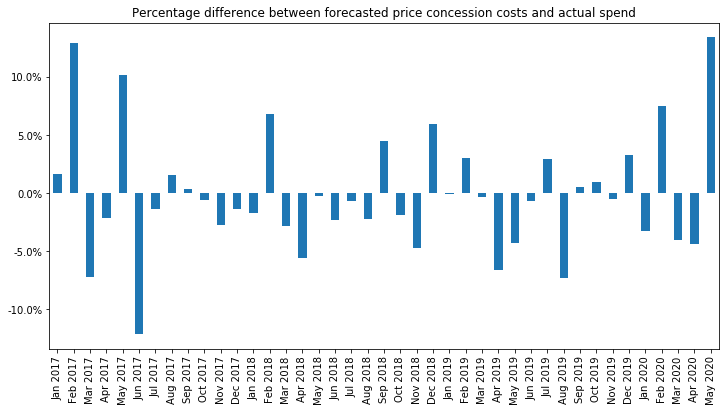

In [8]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), y= ['perc_difference'], legend=None)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs and actual spend')

In [30]:
ncso_total_df['mean_difference'] = ncso_total_df['difference']/ncso_total_df['actual_cost']
ncso_total_df['mean_difference']*100


-0.364379759655311

In [31]:
ncso_sum_df['difference_rolling'] = ncso_sum_df['predicted_cost_rolling'] - ncso_sum_df['actual_cost']  #calculate difference between 3 month average rolling predicted and actual
ncso_sum_df['perc_difference_rolling'] = ncso_sum_df['difference_rolling'] / ncso_sum_df['actual_cost'] #calculate percentage difference on 3 month rolling

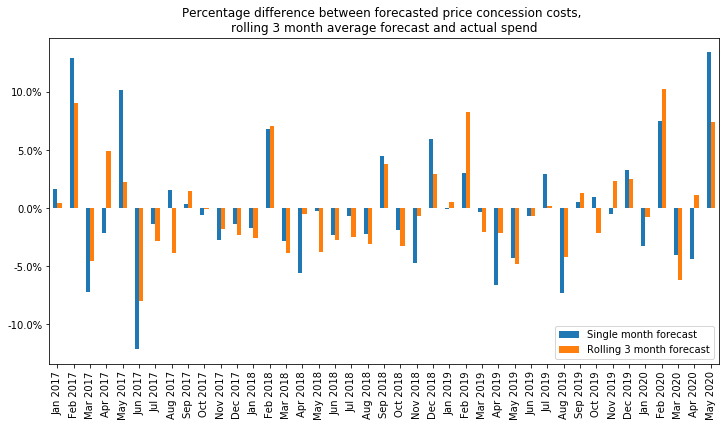

In [32]:
ax = ncso_sum_df.plot.bar(figsize = (12,6), y=['perc_difference', 'perc_difference_rolling'])
ax.xaxis.set_major_formatter(plt.FixedFormatter(ncso_sum_df['rx_month'].dt.strftime("%b %Y"))) #this formats date as string in desired format for x axis, formats here: https://www.ibm.com/support/knowledgecenter/SS6V3G_5.3.1/com.ibm.help.gswapplintug.doc/GSW_strdate.html
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=None)) ##sets y axis labels as percent (and formats correctly i.e. x100)
ax.set_title('Percentage difference between forecasted price concession costs, \nrolling 3 month average forecast and actual spend')
ax.legend(["Single month forecast", "Rolling 3 month forecast"])